In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split

from src.preprocess import transform_to_data_loader
from src.train import train_model

from torchinfo import summary
from torchaudio.transforms import MFCC

### Silence detection

In [2]:
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
silence = np.load("silence.npy")
sound = np.load("augmented_data.npy")

sound_indices = random.sample(range(1, sound.shape[0]), silence.shape[0])
sound = sound[sound_indices]


In [4]:
X_silence = np.concatenate((silence, sound), 0)
y_silence = np.concatenate((np.ones(silence.shape[0]), np.zeros(sound.shape[0])), 0)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_silence, y_silence, test_size=0.2, random_state=42
)

X_train = np.expand_dims(X_train, 1)
X_test = np.expand_dims(X_test, 1)

In [7]:
train_dl = transform_to_data_loader(X_train, y_train, device=device)
val_dl = transform_to_data_loader(X_test, y_test, device=device)

## BI-LSTM

In [14]:
class BiLSTM(nn.Module):
    
    def __init__(self, input_size, hidden_size, dropout, fc_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            batch_first=True, 
            bidirectional=True, 
            num_layers=num_layers,
            dropout=dropout,
        )
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(2*hidden_size, fc_size)  # *2 because of bidirectional
        self.fc2 = nn.Linear(fc_size, 1)
        self.bc1 = nn.BatchNorm1d(2*hidden_size)
        self.bc2 = nn.BatchNorm1d(fc_size)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.lstm(x)[0][:, -1, :]
        out = self.bc1(out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.bc2(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [15]:
input_size = 16000
hidden_size = 32
dropout = 0.3
num_layers = 1
fc_size = 32

bilstm_model = BiLSTM(input_size, hidden_size, dropout, fc_size, num_layers).to(device)
bilstm_criterion = nn.BCELoss()
bilstm_optimizer = optim.Adam(bilstm_model.parameters(), weight_decay=0.0001)

summary(bilstm_model, (1, 1, 16000))

c:\Users\lukgr\anaconda3\envs\venv\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Layer (type:depth-idx)                   Output Shape              Param #
BiLSTM                                   [1, 1]                    --
├─LSTM: 1-1                              [1, 1, 64]                4,104,704
├─BatchNorm1d: 1-2                       [1, 64]                   128
├─Linear: 1-3                            [1, 32]                   2,080
├─Dropout: 1-4                           [1, 32]                   --
├─ReLU: 1-5                              [1, 32]                   --
├─BatchNorm1d: 1-6                       [1, 32]                   64
├─Linear: 1-7                            [1, 1]                    33
├─Sigmoid: 1-8                           [1, 1]                    --
Total params: 4,107,009
Trainable params: 4,107,009
Non-trainable params: 0
Total mult-adds (M): 4.11
Input size (MB): 0.06
Forward/backward pass size (MB): 0.00
Params size (MB): 16.43
Estimated Total Size (MB): 16.49

In [16]:
bilstm_train_losses, bilstm_val_losses = train_model(
    model=bilstm_model,
    criterion=bilstm_criterion,
    optimizer=bilstm_optimizer,
    train_loader=train_dl,
    val_loader=val_dl, 
    model_type="bin", 
    epoch_count=50,
    early_stopping=True,
    device=device
)

Epoch 1: 100%|██████████| 55/55 [00:00<00:00, 68.28it/s]


Epoch 1/50, Train Loss: 0.5834, Train Acc: 0.67, Val Loss: 0.4751, Val Acc: 0.82


Epoch 2: 100%|██████████| 55/55 [00:00<00:00, 83.97it/s]


Epoch 2/50, Train Loss: 0.3665, Train Acc: 0.87, Val Loss: 0.3675, Val Acc: 0.85


Epoch 3: 100%|██████████| 55/55 [00:00<00:00, 84.62it/s]


Epoch 3/50, Train Loss: 0.2254, Train Acc: 0.91, Val Loss: 0.3033, Val Acc: 0.86


Epoch 4: 100%|██████████| 55/55 [00:00<00:00, 81.11it/s]


Epoch 4/50, Train Loss: 0.1587, Train Acc: 0.94, Val Loss: 0.3001, Val Acc: 0.86


Epoch 5: 100%|██████████| 55/55 [00:00<00:00, 87.30it/s]


Epoch 5/50, Train Loss: 0.1243, Train Acc: 0.95, Val Loss: 0.3092, Val Acc: 0.86


Epoch 6: 100%|██████████| 55/55 [00:00<00:00, 84.45it/s]


Epoch 6/50, Train Loss: 0.1141, Train Acc: 0.95, Val Loss: 0.3335, Val Acc: 0.88


Epoch 7: 100%|██████████| 55/55 [00:00<00:00, 91.29it/s]

Epoch 7/50, Train Loss: 0.0989, Train Acc: 0.96, Val Loss: 0.3427, Val Acc: 0.88
Early stopping


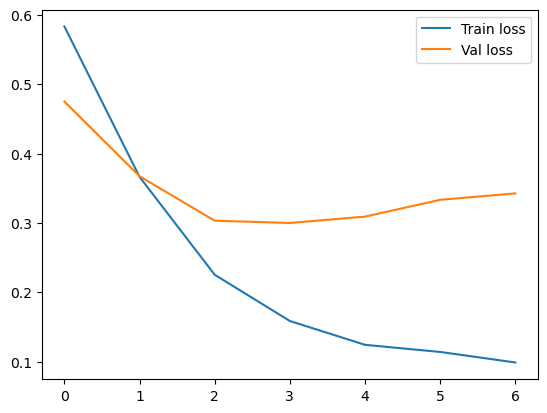

In [17]:
plt.plot(bilstm_train_losses)
plt.plot(bilstm_val_losses)
plt.legend(["Train loss", "Val loss"])
plt.show()

## GRU

In [18]:
class GRU(nn.Module):
    
    def __init__(self, input_size, hidden_size, dropout, fc_size, num_layers):
        super().__init__()
        self.lstm = nn.GRU(
            input_size=input_size, 
            hidden_size=hidden_size, 
            batch_first=True, 
            num_layers=num_layers,
            dropout=dropout,
        )
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, 1)
        self.fc2 = nn.Linear(fc_size, 1)
        self.bc1 = nn.BatchNorm1d(hidden_size)
        self.bc2 = nn.BatchNorm1d(fc_size)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.lstm(x)[0][:, -1, :]
        out = self.dropout(out)
        out = self.bc1(out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.bc2(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [19]:
input_size = 16000
hidden_size = 32
dropout = 0.3
num_layers = 1
fc_size = 32

gru_model = BiLSTM(input_size, hidden_size, dropout, fc_size, num_layers).to(device)
gru_criterion = nn.BCELoss()
gru_optimizer = optim.Adam(gru_model.parameters(), weight_decay=0.0001)

summary(gru_model, (1, 1, 16000))

Layer (type:depth-idx)                   Output Shape              Param #
BiLSTM                                   [1, 1]                    --
├─LSTM: 1-1                              [1, 1, 64]                4,104,704
├─BatchNorm1d: 1-2                       [1, 64]                   128
├─Linear: 1-3                            [1, 32]                   2,080
├─Dropout: 1-4                           [1, 32]                   --
├─ReLU: 1-5                              [1, 32]                   --
├─BatchNorm1d: 1-6                       [1, 32]                   64
├─Linear: 1-7                            [1, 1]                    33
├─Sigmoid: 1-8                           [1, 1]                    --
Total params: 4,107,009
Trainable params: 4,107,009
Non-trainable params: 0
Total mult-adds (M): 4.11
Input size (MB): 0.06
Forward/backward pass size (MB): 0.00
Params size (MB): 16.43
Estimated Total Size (MB): 16.49

In [20]:
gru_train_losses, gru_val_losses = train_model(
    model=gru_model,
    criterion=gru_criterion,
    optimizer=gru_optimizer,
    train_loader=train_dl,
    val_loader=val_dl, 
    model_type="bin", 
    epoch_count=50,
    early_stopping=True,
    device=device
)

Epoch 1: 100%|██████████| 55/55 [00:00<00:00, 74.81it/s]


Epoch 1/50, Train Loss: 0.5776, Train Acc: 0.67, Val Loss: 0.4559, Val Acc: 0.83


Epoch 2: 100%|██████████| 55/55 [00:00<00:00, 81.96it/s]


Epoch 2/50, Train Loss: 0.3570, Train Acc: 0.87, Val Loss: 0.3454, Val Acc: 0.86


Epoch 3: 100%|██████████| 55/55 [00:00<00:00, 90.31it/s]


Epoch 3/50, Train Loss: 0.2225, Train Acc: 0.91, Val Loss: 0.2832, Val Acc: 0.86


Epoch 4: 100%|██████████| 55/55 [00:00<00:00, 81.91it/s]


Epoch 4/50, Train Loss: 0.1579, Train Acc: 0.93, Val Loss: 0.2765, Val Acc: 0.86


Epoch 5: 100%|██████████| 55/55 [00:00<00:00, 86.21it/s]


Epoch 5/50, Train Loss: 0.1212, Train Acc: 0.95, Val Loss: 0.2866, Val Acc: 0.88


Epoch 6: 100%|██████████| 55/55 [00:00<00:00, 85.54it/s]


Epoch 6/50, Train Loss: 0.1124, Train Acc: 0.95, Val Loss: 0.3294, Val Acc: 0.88


Epoch 7: 100%|██████████| 55/55 [00:00<00:00, 81.54it/s]


Epoch 7/50, Train Loss: 0.0971, Train Acc: 0.96, Val Loss: 0.3391, Val Acc: 0.89
Early stopping


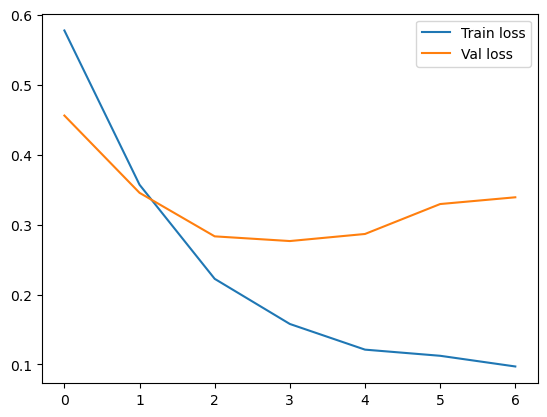

In [21]:
plt.plot(gru_train_losses)
plt.plot(gru_val_losses)
plt.legend(["Train loss", "Val loss"])
plt.show()

## Transformer

In [10]:
transform = MFCC(sample_rate=16000, n_mfcc=10, melkwargs={"n_fft": 400, "hop_length": 315, "n_mels": 20, "center": False})
X_silence_trans = transform(torch.from_numpy(X_silence))

X_train, X_test, y_train, y_test = train_test_split(
    X_silence_trans, y_silence, test_size=0.2, random_state=222
)

In [10]:
train_dl = transform_to_data_loader(X_train, y_train, device=device)
val_dl = transform_to_data_loader(X_test, y_test, device=device)

c:\Users\lukgr\Desktop\Deep_learning\PROJEKT_2\2024L-Deep-Learning-P2-Transformers\src\preprocess.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_t = torch.tensor(X, dtype=torch.float32)


In [12]:
class Transformer(nn.Module):
    
    def __init__(self, d_model, n_head, num_layers, dropout, fc_size):
        super().__init__()
        self.trans_enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=n_head, 
            batch_first=True, 
            activation="relu", 
            dropout=dropout
        ).to(device)
        self.transformer_encoder = nn.TransformerEncoder(self.trans_enc_layer, num_layers=num_layers).to(device)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(d_model, fc_size)
        self.fc2 = nn.Linear(fc_size, 1)
        self.bc1 = nn.BatchNorm1d(d_model)
        self.bc2 = nn.BatchNorm1d(fc_size)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.transformer_encoder(x)[:, -1, :]
        out = self.dropout(out)
        out = self.bc1(out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.bc2(out)
        out = self.fc2(out)
        out = self.dropout(out)
        out = self.sigmoid(out)
        return out

In [14]:
d_model = 50
n_head = 5
num_layers = 1
dropout = 0.3 
fc_size = 32

transformer_model = Transformer(d_model, n_head, num_layers, dropout, fc_size).to(device)
transformer_criterion = nn.BCELoss()
transformer_optimizer = optim.Adam(transformer_model.parameters())

summary(transformer_model, (1, 10, 50))

c:\Users\lukgr\anaconda3\envs\venv\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
c:\Users\lukgr\anaconda3\envs\venv\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Layer (type:depth-idx)                        Output Shape              Param #
Transformer                                   [1, 1]                    217,298
├─TransformerEncoder: 1-1                     [1, 10, 50]               --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 10, 50]               217,298
├─Dropout: 1-2                                [1, 50]                   --
├─BatchNorm1d: 1-3                            [1, 50]                   100
├─Linear: 1-4                                 [1, 32]                   1,632
├─Dropout: 1-5                                [1, 32]                   --
├─ReLU: 1-6                                   [1, 32]                   --
├─BatchNorm1d: 1-7                            [1, 32]                   64
├─Linear: 1-8                                 [1, 1]                    33
├─Dropout: 1-9                                [1, 1]                    --
├─Sigm

In [15]:
transformer_train_losses, transformer_val_losses = train_model(
    model=transformer_model,
    criterion=transformer_criterion,
    optimizer=transformer_optimizer,
    train_loader=train_dl,
    val_loader=val_dl, 
    model_type="bin", 
    epoch_count=50,
    early_stopping=True,
    device=device
)

Epoch 1: 100%|██████████| 55/55 [00:01<00:00, 46.50it/s]


Epoch 1/50, Train Loss: 0.6370, Train Acc: 0.60, Val Loss: 0.4280, Val Acc: 0.85


Epoch 2: 100%|██████████| 55/55 [00:00<00:00, 112.64it/s]


Epoch 2/50, Train Loss: 0.5133, Train Acc: 0.71, Val Loss: 0.2709, Val Acc: 0.93


Epoch 3: 100%|██████████| 55/55 [00:00<00:00, 110.66it/s]


Epoch 3/50, Train Loss: 0.4134, Train Acc: 0.78, Val Loss: 0.1696, Val Acc: 0.95


Epoch 4: 100%|██████████| 55/55 [00:00<00:00, 113.40it/s]


Epoch 4/50, Train Loss: 0.3761, Train Acc: 0.79, Val Loss: 0.1450, Val Acc: 0.96


Epoch 5: 100%|██████████| 55/55 [00:00<00:00, 112.71it/s]


Epoch 5/50, Train Loss: 0.3603, Train Acc: 0.79, Val Loss: 0.1368, Val Acc: 0.95


Epoch 6: 100%|██████████| 55/55 [00:00<00:00, 112.88it/s]


Epoch 6/50, Train Loss: 0.3537, Train Acc: 0.80, Val Loss: 0.1249, Val Acc: 0.97


Epoch 7: 100%|██████████| 55/55 [00:00<00:00, 116.78it/s]


Epoch 7/50, Train Loss: 0.3370, Train Acc: 0.80, Val Loss: 0.1181, Val Acc: 0.96


Epoch 8: 100%|██████████| 55/55 [00:00<00:00, 114.35it/s]


Epoch 8/50, Train Loss: 0.3423, Train Acc: 0.80, Val Loss: 0.1176, Val Acc: 0.96


Epoch 9: 100%|██████████| 55/55 [00:00<00:00, 112.94it/s]


Epoch 9/50, Train Loss: 0.3358, Train Acc: 0.81, Val Loss: 0.1328, Val Acc: 0.96


Epoch 10: 100%|██████████| 55/55 [00:00<00:00, 111.09it/s]


Epoch 10/50, Train Loss: 0.3287, Train Acc: 0.81, Val Loss: 0.1084, Val Acc: 0.97


Epoch 11: 100%|██████████| 55/55 [00:00<00:00, 115.30it/s]


Epoch 11/50, Train Loss: 0.3252, Train Acc: 0.81, Val Loss: 0.1068, Val Acc: 0.97


Epoch 12: 100%|██████████| 55/55 [00:00<00:00, 113.40it/s]


Epoch 12/50, Train Loss: 0.3211, Train Acc: 0.81, Val Loss: 0.0995, Val Acc: 0.97


Epoch 13: 100%|██████████| 55/55 [00:00<00:00, 113.87it/s]


Epoch 13/50, Train Loss: 0.3278, Train Acc: 0.81, Val Loss: 0.1024, Val Acc: 0.97


Epoch 14: 100%|██████████| 55/55 [00:00<00:00, 109.03it/s]


Epoch 14/50, Train Loss: 0.3321, Train Acc: 0.81, Val Loss: 0.1111, Val Acc: 0.97


Epoch 15: 100%|██████████| 55/55 [00:00<00:00, 114.33it/s]


Epoch 15/50, Train Loss: 0.3212, Train Acc: 0.81, Val Loss: 0.1166, Val Acc: 0.97
Early stopping


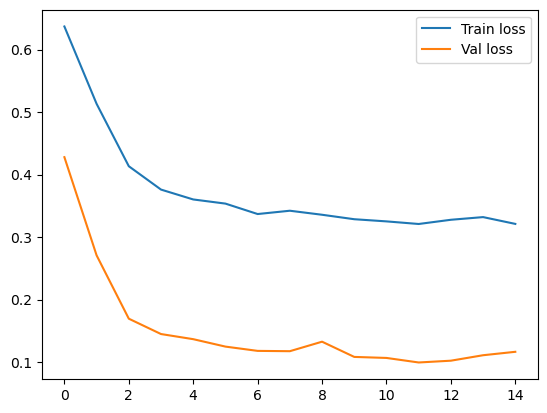

In [16]:
plt.plot(transformer_train_losses)
plt.plot(transformer_val_losses)
plt.legend(["Train loss", "Val loss"])
plt.show()